# Project Part 2

In [70]:
import pandas as pd
import numpy as np

x = 'tweet'
y = 'class'
file = 'labeled_data.csv'

df = pd.read_csv(file)
#df = df[0:10000]
print(f"df.shape: {df.shape}")
df[[x,y]].head(10)

df.shape: (24783, 7)


,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",1
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",1
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,1
8,""" &amp; you might not get ya bitch back &amp; ...",1
9,""" @rhythmixx_ :hobbies include: fighting Maria...",1


In [71]:
print(df[y].value_counts(normalize=True))
print('0 = Hate Speech, 1 = Offensive Language, 2 = Neither')

1    0.774321
2    0.167978
0    0.057701
Name: class, dtype: float64
0 = Hate Speech, 1 = Offensive Language, 2 = Neither


### Data Cleaning

In [72]:
from textblob import TextBlob, Word, Blobber
from nltk.stem import PorterStemmer
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Converting data set to String type
df['tweet'] = df['tweet'].astype(str)
df = df[~df["tweet"].isnull()]

# Special character cleaning
def clean(txt):
    txt = txt.str.replace("()", "")
    txt = txt.str.replace('(<a).*(>).*()', '')
    txt = txt.str.replace('(&amp)', '')
    txt = txt.str.replace('(&gt)', '')
    txt = txt.str.replace('(&lt)', '')
    txt = txt.str.replace('(\xa0)', ' ')  
    return txtdf['tweet'] == clean(df['tweet'])

# Converting to lower case
df['cleanText'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print("lower case done")

# Removing Stopwords
stop = stopwords.words('english')
df['cleanText'] = df['cleanText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
print("stopwords done")

# Correcting any spelling mistake in the dataset
#df['cleanText'].apply(lambda x: str(TextBlob(x).correct()))
#print('spelling done')

# Stemming words in the dataset
st = PorterStemmer()
df['cleanText'] = df['cleanText'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
print('stemming done')

# Removing punctiation
df['cleanText'] = df['cleanText'].str.replace('[^\w\s]', '')

df[['cleanText', 'class']].head(10)

lower case done
stopwords done
stemming done


/var/folders/zc/w3_gp3bj2r75g6hkvhz1zd4w0000gn/T/ipykernel_20040/1241202080.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleanText'] = df['cleanText'].str.replace('[^\w\s]', '')


,cleanText,class
0,rt mayasolovely woman complain clean house am...,2
1,rt mleew17 boy dat coldtyga dwn bad cuffin da...,1
2,rt urkindofbrand dawg rt 80sbaby4life ever fu...,1
3,rt c_g_anderson viva_bas look like tranni,1
4,rt shenikaroberts shit hear might true might ...,1
5,t_madison_x shit blow meclaim faith somebodi s...,1
6,__brighterdays sit hate anoth bitch got much ...,1
7,8220selfiequeenbri caus im tire big bitch come...,1
8,amp might get ya bitch back amp that,1
9,rhythmixx_ hobbi include fight mariam bitch,1


### Split data into train and validations sets.

In [73]:
from sklearn.model_selection import train_test_split

X = df['cleanText'].copy()
y = df['class'].copy()

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, train_size=0.8)

X_val, X_test, y_val, y_test = train_test_split(X_remaining,y_remaining,test_size=0.5)

print(X_train.shape),print(y_train.shape)
print(X_val.shape),print(y_val.shape)
print(X_test.shape),print(y_test.shape)

(19826,)
(19826,)
(2478,)
(2478,)
(2479,)
(2479,)


(None, None)

#### Random Forest Classifier and Display

accuracy (on X_train): 0.9996


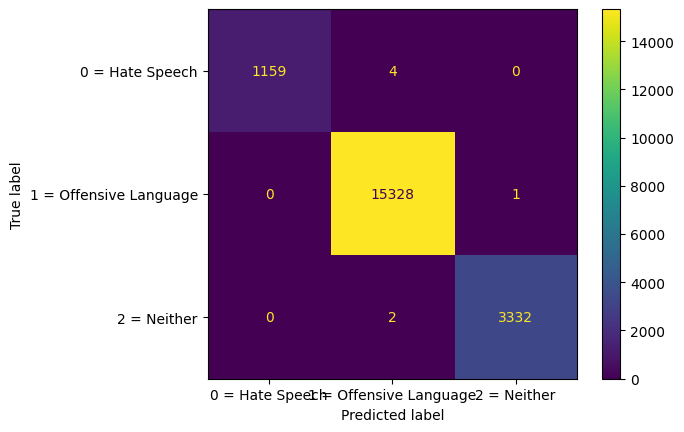

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

X_train_vect = tfidf_vectorizer.fit_transform(X_train).toarray()

model = RandomForestClassifier(n_estimators=50)
model = model.fit(X_train_vect, y_train)

predictions_train = model.predict(X_train_vect)

display = ConfusionMatrixDisplay(confusion_matrix(y_train, predictions_train),
display_labels=['0 = Hate Speech', '1 = Offensive Language', '2 = Neither'])
display.plot()
print(f"accuracy (on X_train): {accuracy_score(y_train,predictions_train):.4f}")

add scores here

accuracy (on X_train): 0.8805


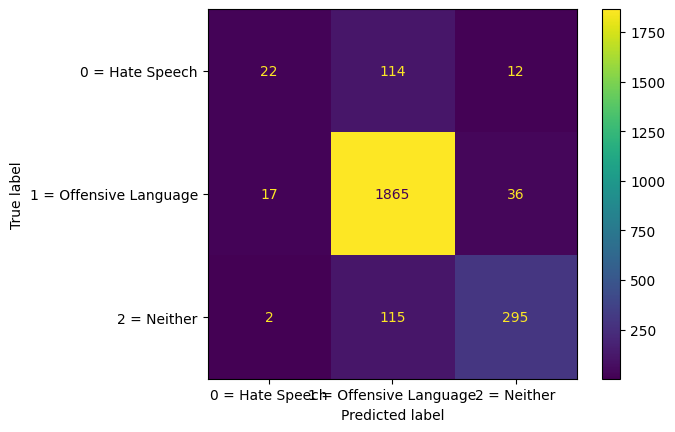

In [75]:
X_val_vect = tfidf_vectorizer.transform(X_val).toarray()
predictions_val = model.predict(X_val_vect)

disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val), display_labels=['0 = Hate Speech', '1 = Offensive Language', '2 = Neither'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_val, predictions_val):.4f}")

In [80]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

def tuneModel(hp_value,param):
    if param == 'min_samples_split':
        rf_model = RandomForestClassifier(min_samples_split=hp_value)#,n_estimators=hp_value)
    else:
        rf_model = RandomForestClassifier(n_estimators=hp_value)
    rf_model.fit(X_train_vect, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train_vect)
    y_train_pred = rf_model.predict(X_train_vect)
    y_val_pred_prob = rf_model.predict_proba(X_val_vect)
    y_val_pred = rf_model.predict(X_val_vect)
    train_loss = log_loss(y_train, y_train_pred_prob,labels=['Hate Speech', 'Offensive Language','Neither'])
    train_acc = accuracy_score(y_train,y_train_pred)
    val_loss = log_loss(y_val,y_val_pred_prob,labels=['Hate Speech', 'Offensive Language','Neither'])
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

def loss_and_accuracy_plot(metrics, hyp_param_vals,x_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel=x_label, ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel=x_label, ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)


/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/pyt

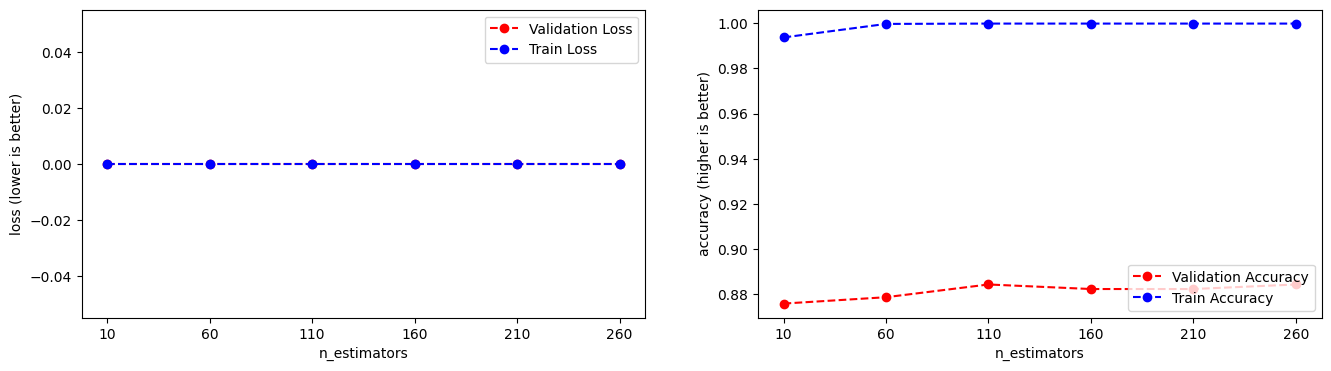

In [81]:
# n_estimators
n_hyp_param_values = list(range(10,261,50))
metrics = []

for hp in n_hyp_param_values:
    metrics.append(tuneModel(hp,'n_estimators'))

loss_and_accuracy_plot(metrics, n_hyp_param_values,'n_estimators')


In [82]:
# first row containing hyperparam values, second row containing validation loss, third row containing validation accuracy

tuning_results = np.array([estim_hyp_param_values, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
print(tuning_results)

[[ 10.    60.   110.   160.   210.   260.  ]
 [  0.     0.     0.     0.     0.     0.  ]
 [  0.88   0.88   0.88   0.88   0.88   0.88]]


/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/pyt

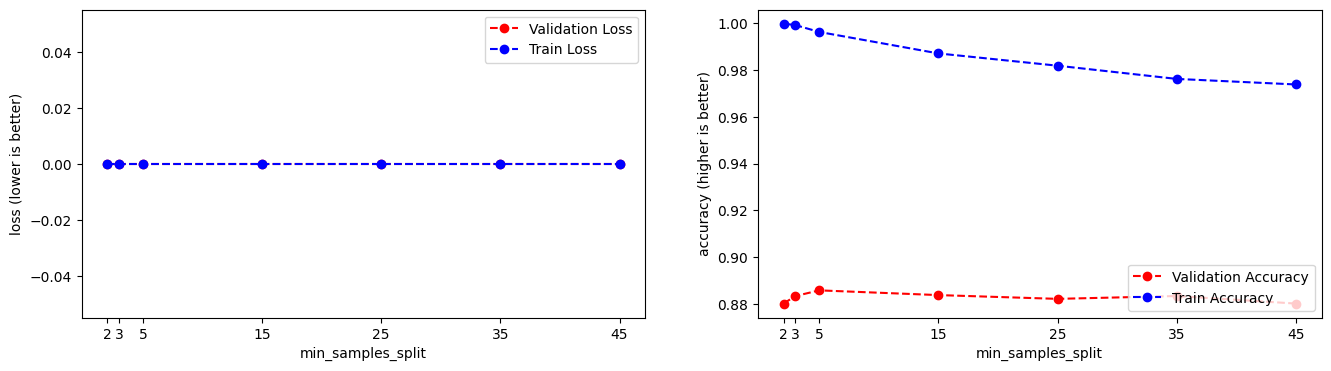

In [83]:
# min_samples_split 
split_hyp_param_values = [2,3] +list(range(5,50,10))

splitsMetrics = []
for hp in split_hyp_param_values:
    splitsMetrics.append(tuneModel(hp,'min_samples_split'))

loss_and_accuracy_plot(splitsMetrics, split_hyp_param_values,'min_samples_split')

In [84]:
# first row containing hyperparam values, second row containing validation loss, third row containing validation accuracy

tuning_results = np.array([split_hyp_param_values, [round(metric[1],2) for metric in splitsMetrics], [round(metric[3],2) for metric in splitsMetrics]])
print(tuning_results)

[[ 2.    3.    5.   15.   25.   35.   45.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.88  0.88  0.89  0.88  0.88  0.88  0.88]]


accuracy (on X_test): 0.8919


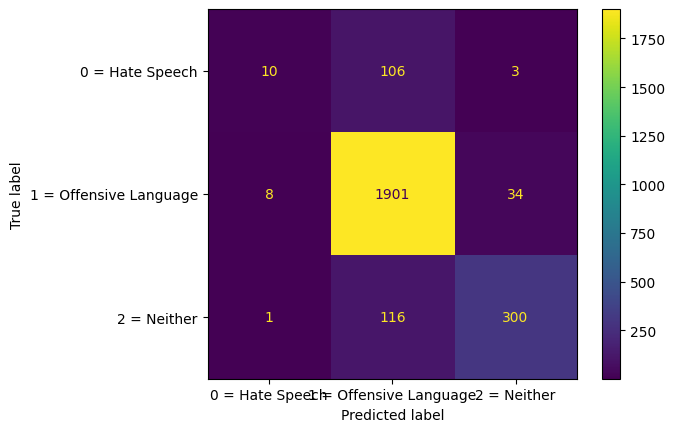

In [85]:
X_test_vect = tfidf_vectorizer.transform(X_test).toarray()

# refit the model with the best hyperparameter value you found
model = RandomForestClassifier(n_estimators=110,min_samples_split=5)
model = model.fit(X_train_vect, y_train)

# this make predictions for the test set
predictions_test = model.predict(X_test_vect)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions_test), display_labels=['0 = Hate Speech', '1 = Offensive Language', '2 = Neither'])
disp.plot()
print(f"accuracy (on X_test): {accuracy_score(y_test,predictions_test):.4f}")